**Some links**

- [Predicting the properties of black holes merger remnants with Deep Neural Networks](https://arxiv.org/abs/1911.01496)
- [The SXS Collaboration catalog of binary black hole simulations](https://arxiv.org/abs/1904.04831)
- [Deep Learning for Real-time Gravitational Wave Detection and Parameter Estimation: Results with Advanced LIGO Data](https://arxiv.org/abs/1711.03121)



Preivous Links 

- predicting w deep learning https://arxiv.org/abs/1911.01496 
- og link https://data.black-holes.org/waveforms/index.html
- some variable definition _maybe_ https://data.black-holes.org/waveforms/extcce_catalog.html 
- raw files (h5) at zenodo https://zenodo.org/record/3312723 
- repo from catalog in github https://github.com/sxs-collaboration/catalog_tools 
- rit catalog https://ccrg.rit.edu/content/data/rit-waveform-catalog
- lal simulation https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/classlalsimulation_1_1nrfits_1_1_n_r_sur7dq4_remnant_1_1_n_r_sur7dq4_remnant.html
- nasa data https://datasetsearch.research.google.com/search?query=gravitational&docid=L2cvMTFqbnptMHE1cg%3D%3D and description file:///Users/camilaburne/Downloads/TechPort%20Data%20Sheet%20Download%2009_26_2021%2008_14%20PM%20UTC.pdf 
- visualizations https://vijayvarma392.github.io/SurrogateMovie


## To do 

- Preprocessing: feat eng
- Apply model from paper
- User stratified sampling? 

**Extra** 
- Extract all data and check that all simulations have the same data over time
- Use Monte Carlo to include error in the mass ratio


In [1]:
import numpy as np
import pandas as pd
import random
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import itertools
import h5py


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Input data: Catalog.json

In [3]:
df = pd.read_json('catalog.json')

In [4]:
df.columns

Index(['url', 'simulation_name', 'alternative_names', 'initial_data_type',
       'object_types', 'number_of_orbits', 'reference_mass_ratio',
       'reference_chi_eff', 'reference_chi1_perp', 'reference_chi2_perp',
       'reference_eccentricity', 'reference_dimensionless_spin1',
       'reference_dimensionless_spin2', 'reference_orbital_frequency',
       'reference_mass1', 'reference_mass2', 'reference_time',
       'reference_position1', 'reference_position2', 'reference_mean_anomaly',
       'keywords', 'point_of_contact_email', 'authors_emails',
       'simulation_bibtex_keys', 'code_bibtex_keys',
       'initial_data_bibtex_keys', 'quasicircular_bibtex_keys',
       'initial_separation', 'initial_orbital_frequency', 'initial_adot',
       'object1', 'object2', 'initial_ADM_energy',
       'initial_ADM_linear_momentum', 'initial_ADM_angular_momentum',
       'initial_mass1', 'initial_mass2', 'initial_dimensionless_spin1',
       'initial_dimensionless_spin2', 'initial_position1',

In [5]:
df.head(2)

,url,simulation_name,alternative_names,initial_data_type,object_types,number_of_orbits,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_dimensionless_spin1,reference_dimensionless_spin2,reference_orbital_frequency,reference_mass1,reference_mass2,reference_time,reference_position1,reference_position2,reference_mean_anomaly,keywords,point_of_contact_email,authors_emails,simulation_bibtex_keys,code_bibtex_keys,initial_data_bibtex_keys,quasicircular_bibtex_keys,initial_separation,initial_orbital_frequency,initial_adot,object1,object2,initial_ADM_energy,initial_ADM_linear_momentum,initial_ADM_angular_momentum,initial_mass1,initial_mass2,initial_dimensionless_spin1,initial_dimensionless_spin2,initial_position1,initial_position2,relaxation_time,common_horizon_time,remnant_mass,remnant_dimensionless_spin,remnant_velocity,metadata_version,spec_revisions,spells_revision,com_parameters,initial_mass_ratio,metadata_path,name,eos,merger_time,final_time,disk_mass,ejecta_mass,reference_spin1,reference_spin2,nitial_spin1,initial_spin2,remnant_spin,initial_mass_withspin2
0,https://doi.org/10.5281/zenodo.1212426,d18.0_q1.0_s0_0_0_s0_0_0/Lev5,SXS:BBH:0001,BBH_CFMS,BHBH,28.119083,1.0,1.215639e-07,9.733309e-10,1.429939e-09,0.000257,"[7.09752141352e-10, -6.66051760901e-10, 1.2093...","[5.84453420303e-10, 1.3050444511300001e-09, 1....","[2.8280852361099996e-13, -8.251591712050001e-1...",0.5,0.5,320.0,"[-6.4605628809799995, -6.21953367941, -3.37886...","[6.46056317772, 6.21953399104, 2.00589477099e-10]",3.083240,"[Non-Spinning, ManyMergers-QuasiCircular]",mroue@cita.utoronto.ca,"[Mike Boyle <boyle@astro.cornell.edu>, Dan Hem...","[Mroue:2013xna, Boyle:2019kee, SXSCatalogWebsite]","[Ossokine:2013zga, Hemberger:2012jz, Szilagyi:...","[Buchman:2012dw, Lovelace:2008tw, Pfeiffer:200...","[Mroue:2012kv, Buonanno:2010yk, Mroue:2010re, ...",18.0,0.012203,-0.000025,bh,bh,0.993736,"[7.5160071e-09, 2.4389069e-09, -5.798632e-10]","[4.27581822e-08, -2.3426250729999996e-07, 1.18...",0.5,0.5,"[-6.35700000002e-13, 4.72400000001e-13, 1.0250...","[4.4999999999800006e-15, -2.8e-15, 1.559379999...","[9.000000125802465, -2.8664642100000002e-08, 0]","[-8.999999874197535, -2.8664642100000002e-08, 0]",320.0,9524.085983,0.951609,"[-7.29520687012e-10, 7.40468371215e-10, 0.6864...","[1.45734870604e-09, 7.51603528474e-10, 3.72053...",1,"[InitialCommit-20603-g8a2e9b6, InitialCommit-2...",InitialCommit-21848-g8d8a7d7,"{'space_translation': [3.6668214400000003e-08,...",1.0,SXS:BBH:0001v6/Lev5/metadata.json,SXS:BBH:0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://doi.org/10.5281/zenodo.1210580,d19.0_q1.0_s0_0_0_s0_0_0/Lev6,SXS:BBH:0002,BBH_CFMS,BHBH,32.421068,1.0,9.399402e-08,7.181763e-10,1.473155e-09,0.000175,"[6.50756283834e-10, -3.03798339473e-10, 9.4840...","[1.0426889812e-09, 1.04066536466e-09, 9.314798...","[2.20978373119e-13, -7.93686620079e-13, 0.0113...",0.5,0.5,310.0,"[-8.87345009522, -3.32815913214, 1.74403931592...","[8.87345005146, 3.32815888263, 2.94462584419e-10]",2.514884,"[Non-Spinning, ManyMergers-QuasiCircular]",mroue@cita.utoronto.ca,"[Mike Boyle <boyle@astro.cornell.edu>, Dan Hem...","[Mroue:2013xna, Boyle:2019kee, SXSCatalogWebsite]","[Ossokine:2013zga, Hemberger:2012jz, Szilagyi:...","[Buchman:2012dw, Lovelace:2008tw, Pfeiffer:200...","[Mroue:2012kv, Buonanno:2010yk, Mroue:2010re, ...",19.0,0.011292,-0.000021,bh,bh,0.994031,"[1.6810827e-09, 1.4244131e-09, -1.148397590000...","[2.7620419800000002e-06, -2.428793193e-06, 1.2...",0.5,0.5,"[5.319329999989999e-11, -6.31285000002e-11, -1...","[-3.268359e-10, 2.252065e-10, -1.44598159e-08]","[9.50000028134381, 2.0830027e-07, 0]","[-9.49999971865619, 2.0830027e-07, 0]",310.0,11804.749017,0.95161,"[3.7521879808300004e-10, 1.3261440201800001e-0...","[3.5996348603100005e-09, 7.181410030280001e-09...",1,"[InitialCommit-20603-g8a2e9b6, InitialCommit-2...",InitialCommit-21848-g8d8a7d7,"{'space_translation': [-4.66496816e-08, 2.4388...",1.0,SXS:BBH:0002v

In [6]:
## Exploring Keywords in DF ## 

#df['keywords']
#df.loc[df.keyword1!='Precessing-Spins',]
df[['keyword1','keyword2','keyword3']] = pd.DataFrame(df.keywords.tolist(), index= df.index)

In [7]:
df.keyword1.value_counts(dropna=False)

NaN                 1845
Precessing-Spins      91
Aligned-Spins         51
Non-Spinning          35
NonSpinning            4
SpinningNS             2
Name: keyword1, dtype: int64

In [8]:
df.keyword2.value_counts(dropna=False)

NaN                          1845
ManyMergers-QuasiCircular      80
ManyMergers-Eccentric          43
ManyMergers-Random32           32
ManyMergers-SKS                19
Polytrope                       8
PiecewisePolytrope              1
Name: keyword2, dtype: int64

In [9]:
predictors = ['alternative_names','reference_mass_ratio', 'reference_dimensionless_spin1',
              'reference_dimensionless_spin2','remnant_mass','keyword1','keyword2','keyword3',
              'reference_chi_eff', 'reference_chi1_perp', 'reference_chi2_perp',
               'reference_mass1', 'reference_mass2'
             ]

In [10]:
# Removing rows with NA values
df_ok = df.loc[0:2018, predictors]

In [11]:
# Removing rows with outliers on remnant_mass
df_ok = df_ok.loc[df_ok.remnant_mass < 1.5,]

In [12]:
df_ok[['reference_dimensionless_spin1_1','reference_dimensionless_spin1_2','reference_dimensionless_spin1_3']] = pd.DataFrame(df_ok.reference_dimensionless_spin1.tolist(), index= df_ok.index)
df_ok[['reference_dimensionless_spin2_1','reference_dimensionless_spin2_2','reference_dimensionless_spin2_3']] = pd.DataFrame(df_ok.reference_dimensionless_spin2.tolist(), index= df_ok.index)

### Adding Flags: Precessing, Not Spinning

In [13]:
df_ok['precessing'] = 1
df_ok.loc[abs(df_ok.reference_dimensionless_spin1_1) < 0.000001, 'precessing'] = 0


df_ok['notspinning'] = 0
df_ok.loc[(abs(df_ok.reference_dimensionless_spin1_1) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin1_2) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin1_3) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin2_1) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin2_2) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin2_3) < 0.0001) 
          , 'notspinning'] = 1


In [14]:
df_ok['notspinning'].value_counts()

0    1912
1     104
Name: notspinning, dtype: int64

In [15]:
df_ok['precessing'].value_counts()

1    1421
0     595
Name: precessing, dtype: int64

### Variables into the model: 

#### X Variables
For hole 1: 
- $\chi_{1.1}$ = reference_dimensionless_spin1_1
- $\chi_{1.2}$ = reference_dimensionless_spin1_2
- $\chi_{1.2}$ = reference_dimensionless_spin1_3


For hole 2: 
- $\chi_{2.1}$ = reference_dimensionless_spin2_1
- $\chi_{2.2}$ = reference_dimensionless_spin2_2
- $\chi_{2.2}$ = reference_dimensionless_spin2_3


For both: 
- $q$ = reference_mass_ratio

#### Y (Target) Variable 
- $m_f$ = remnant_mass




### Calculated stats: 
- $\eta$ = reference_mass_ratio / (1+reference_mass_ratio **2)
- $S1 = |\chi_{1}|$
- $S2 = |\chi_{2}|$
- $S_{eff} = (S1+S2)/(1−2 η M2)$

In [16]:
df_ok['s1'] = df_ok['reference_dimensionless_spin1_1']**2 +  df_ok['reference_dimensionless_spin1_2']**2 +  df_ok['reference_dimensionless_spin1_3']**2
df_ok['s1'] = np.sqrt(df_ok['s1'])

df_ok['s2'] = df_ok['reference_dimensionless_spin2_1']**2 +  df_ok['reference_dimensionless_spin2_2']**2 +  df_ok['reference_dimensionless_spin2_3']**2
df_ok['s2'] = np.sqrt(df_ok['s2'])

In [17]:
df_ok['eta'] = df_ok['reference_mass_ratio'] / (df_ok['reference_mass_ratio']+1)**2

In [18]:
df_ok['s1_sum'] = df_ok['reference_dimensionless_spin1_1'] + df_ok['reference_dimensionless_spin2_1']
df_ok['s2_sum'] = df_ok['reference_dimensionless_spin1_2'] + df_ok['reference_dimensionless_spin2_2']
df_ok['s3_sum'] = df_ok['reference_dimensionless_spin1_3'] + df_ok['reference_dimensionless_spin2_3']
df_ok['m1+m2']  = df_ok['reference_mass1'] + df_ok['reference_mass2']
df_ok['seff'] = np.sqrt(df_ok.s1_sum**2 + df_ok.s2_sum**2 + df_ok.s3_sum**2) / (1 - (2*df_ok['eta']*df_ok['m1+m2']**2)) 

In [20]:
#df.to_csv('/Users/camilaburne/UT/Data Mining/Data-Mining-ECE-280/LIDO/df_raw.csv')

In [22]:
df_ok.to_csv('/Users/camilaburne/UT/Data Mining/Data-Mining-ECE-280/LIDO/df_predictors.csv')

In [23]:
df_ok.columns

Index(['alternative_names', 'reference_mass_ratio',
       'reference_dimensionless_spin1', 'reference_dimensionless_spin2',
       'remnant_mass', 'keyword1', 'keyword2', 'keyword3', 'reference_chi_eff',
       'reference_chi1_perp', 'reference_chi2_perp', 'reference_mass1',
       'reference_mass2', 'reference_dimensionless_spin1_1',
       'reference_dimensionless_spin1_2', 'reference_dimensionless_spin1_3',
       'reference_dimensionless_spin2_1', 'reference_dimensionless_spin2_2',
       'reference_dimensionless_spin2_3', 'precessing', 'notspinning', 's1',
       's2', 'eta', 's1_sum', 's2_sum', 's3_sum', 'm1+m2', 'seff'],
      dtype='object')

### Exploratory Data Analysis 

In [24]:
X = df_ok[['reference_mass_ratio',
       'reference_dimensionless_spin1', 'reference_dimensionless_spin2',
       'reference_chi_eff',
       'reference_chi1_perp', 'reference_chi2_perp', 'reference_mass1',
       'reference_mass2', 'reference_dimensionless_spin1_1',
       'reference_dimensionless_spin1_2', 'reference_dimensionless_spin1_3',
       'reference_dimensionless_spin2_1', 'reference_dimensionless_spin2_2',
       'reference_dimensionless_spin2_3', 'precessing', 'notspinning', 's1',
       's2', 'eta', 's1_sum', 's2_sum', 's3_sum', 'm1+m2', 'seff']]

y = df_ok['remnant_mass']


In [ ]:
X.columns

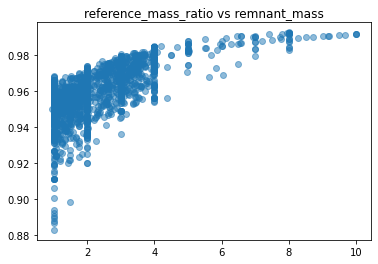

ValueError: setting an array element with a sequence.

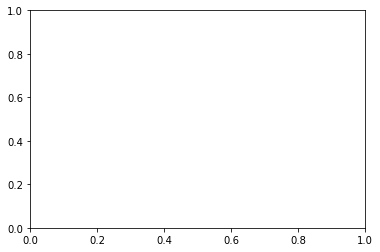

In [25]:
for i in X.columns:
    plt.scatter(X[i], y, alpha = 0.5)
    plt.title(i + ' vs remnant_mass')
    plt.show()

This is just a test to implement the following model
$$m_f=\omega_0+\omega_1 q+\omega_2 \chi^1_x+\omega_3 \chi^1_y+\omega_4 \chi^1_z+\omega_5 \chi^2_x+\omega_6 \chi^2_y+\omega_7 \chi^2_z$$

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

In [ ]:
Reg_Linear = linear_model.LinearRegression()
Linear_fit = Reg_Linear.fit(X_train,y_train)
Linear_predict = Linear_fit.predict(X_test)
mse_Linear = mean_squared_error(y_test,Linear_predict)
#Rsquared_Linear=Linear_fit.score(X_test,y_test)
#Rsquared_Linear_2=Linear_fit.score(X_train,y_train)

In [ ]:
Linear_fit

In [ ]:
mse_Linear

In [ ]:
plt.scatter(X_test['reference_mass_ratio'],y_test)
plt.title('reference_mass_ratio vs remnant_mass')
plt.show()

In [ ]:
plt.scatter(S1,y_test)
plt.title('S1 vs remnant_mass')
plt.show()

In [ ]:
plt.scatter(S2,y_test)
plt.title('S2 vs remnant_mass')
plt.show()

In [ ]:
plt.scatter(eta,y_test)
plt.title('eta vs remnant_mass')
plt.show()

#### Horizons.h5
NOTE: This file contains raw output from SpEC simulations. Coordinates t,x,y,z and dimensionful quantities in this file are in "code units", which are related to the total mass of the corresponding SpEC simulation. We use geometrized units, where G=c=1.

This HDF5 file contains information about the black holes' apparent horizons as a function of coordinate time t in code units (not retarded time). We call the individual apparent horizons AhA and AhB, and we call the common apparent horizon AhC. Horizons.h5 contains one h5-group for each apparent horizon: AhA.dir, AhB.dir, and AhC.dir. The following datasets are provided:

``` 
# ArealMass.dat                   Cols (t,Mirr)
  Mirr is the areal (irreducible) mass sqrt(A/16π), 
  where A is the horizon surface area.

# ChristodoulouMass.dat           Cols (t,M)
  Christodoulou mass M, where M2=M2irr+S2/4M2irr and S is the 
  magnitude of the spin angular momentum of the black hole 
  (as given in DimensionfulInertialSpinMag.dat).

# CoordCenterInertial.dat         Cols (t,x,y,z)
  x ,y,z are the Cartesian coordinates of the center of the apparent
  horizon, in the "inertial frame," the asymptotically inertial frame 
  in which the gravitational waves are measured.

# DimensionfulInertialSpin.dat    Cols (t,Sx,Sy,Sz)	
  Si are the Cartesian vector components of the spin angular momentum 
  measured on the apparent horizon in the "inertial frame". The spin 
  is measured using approximate rotational Killing vectors (see 
  Appendix A in arXiv:0805.4192 for details of the method used to 
  measure the spin).

# DimensionfulInertialSpinMag.dat Cols (t,S)
  S is the Euclidean magnitude of the black-hole spin angular 
  momentum given in DimensionfulInertialSpin.dat, S2=S2x+S2y+S2z.

# chiInertial.dat                 Cols (t,χx,χy,χz)
  χi=Si/M2, i.e., the Cartesian components of the spin angular
  momentum measured in the "inertial frame", made dimensionless
  by dividing by the square of the Christodoulou mass.
  
# chiMagInertial.dat              Cols (t,χ)
  χ is the Euclidean magnitude of the dimensionless spin angular
  momentum measured on the apparent horizon, χ2=χ2x+χ2y+χ2z.
  
```